# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


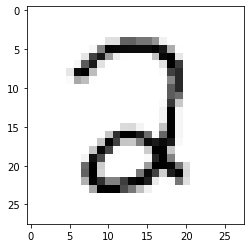

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2523
Training Accuracy: 0.6200, Testing Accuracy: 0.6321



Epoch 10, Loss 0.0953
Training Accuracy: 0.9104, Testing Accuracy: 0.9229



Epoch 20, Loss 0.058
Training Accuracy: 0.9390, Testing Accuracy: 0.9461



Epoch 30, Loss 0.0455
Training Accuracy: 0.9507, Testing Accuracy: 0.9582



Epoch 40, Loss 0.0394
Training Accuracy: 0.9564, Testing Accuracy: 0.9622



Epoch 50, Loss 0.0357
Training Accuracy: 0.9597, Testing Accuracy: 0.9657



Epoch 60, Loss 0.0331
Training Accuracy: 0.9624, Testing Accuracy: 0.9657



Epoch 70, Loss 0.0312
Training Accuracy: 0.9644, Testing Accuracy: 0.9657



Epoch 80, Loss 0.0297
Training Accuracy: 0.9659, Testing Accuracy: 0.9667



Epoch 90, Loss 0.0284
Training Accuracy: 0.9673, Testing Accuracy: 0.9667



Epoch 100, Loss 0.0273
Training Accuracy: 0.9682, Testing Accuracy: 0.9688



Epoch 110, Loss 0.0264
Training Accuracy: 0.9695, Testing Accuracy: 0.9703



Epoch 120, Loss 0.0256
Training Accuracy: 0.9705, Testing Accuracy: 0.9708



Epoch 130, Loss 0.0249
Training Accuracy: 0.9715, Testing Accuracy: 0.9713



Epoch 140, Loss 0.0243
Training Accuracy: 0.9722, Testing Accuracy: 0.9708



Epoch 150, Loss 0.0237
Training Accuracy: 0.9726, Testing Accuracy: 0.9713



Epoch 160, Loss 0.0232
Training Accuracy: 0.9733, Testing Accuracy: 0.9713



Epoch 170, Loss 0.0227
Training Accuracy: 0.9737, Testing Accuracy: 0.9723



Epoch 180, Loss 0.0223
Training Accuracy: 0.9746, Testing Accuracy: 0.9723



Epoch 190, Loss 0.0218
Training Accuracy: 0.9753, Testing Accuracy: 0.9723



Epoch 200, Loss 0.0214
Training Accuracy: 0.9755, Testing Accuracy: 0.9723



Epoch 210, Loss 0.0211
Training Accuracy: 0.9761, Testing Accuracy: 0.9718



Epoch 220, Loss 0.0207
Training Accuracy: 0.9760, Testing Accuracy: 0.9723



Epoch 230, Loss 0.0203
Training Accuracy: 0.9765, Testing Accuracy: 0.9718



Epoch 240, Loss 0.02
Training Accuracy: 0.9775, Testing Accuracy: 0.9723



0.023353448444070255

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2402
Training Accuracy: 0.6941, Testing Accuracy: 0.7233



Epoch 10, Loss 0.1004
Training Accuracy: 0.9147, Testing Accuracy: 0.9304



Epoch 20, Loss 0.0776
Training Accuracy: 0.9297, Testing Accuracy: 0.9435



Epoch 30, Loss 0.0671
Training Accuracy: 0.9382, Testing Accuracy: 0.9511



Epoch 40, Loss 0.0607
Training Accuracy: 0.9425, Testing Accuracy: 0.9551



Epoch 50, Loss 0.0564
Training Accuracy: 0.9458, Testing Accuracy: 0.9582



Epoch 60, Loss 0.0532
Training Accuracy: 0.9486, Testing Accuracy: 0.9597



Epoch 70, Loss 0.0507
Training Accuracy: 0.9511, Testing Accuracy: 0.9607



Epoch 80, Loss 0.0487
Training Accuracy: 0.9524, Testing Accuracy: 0.9622



Epoch 90, Loss 0.0471
Training Accuracy: 0.9539, Testing Accuracy: 0.9632



Epoch 100, Loss 0.0457
Training Accuracy: 0.9544, Testing Accuracy: 0.9637



Epoch 110, Loss 0.0445
Training Accuracy: 0.9553, Testing Accuracy: 0.9657



Epoch 120, Loss 0.0435
Training Accuracy: 0.9564, Testing Accuracy: 0.9662



Epoch 130, Loss 0.0425
Training Accuracy: 0.9570, Testing Accuracy: 0.9662



Epoch 140, Loss 0.0417
Training Accuracy: 0.9579, Testing Accuracy: 0.9667



Epoch 150, Loss 0.041
Training Accuracy: 0.9582, Testing Accuracy: 0.9672



Epoch 160, Loss 0.0403
Training Accuracy: 0.9585, Testing Accuracy: 0.9677



Epoch 170, Loss 0.0397
Training Accuracy: 0.9589, Testing Accuracy: 0.9682



Epoch 180, Loss 0.0392
Training Accuracy: 0.9594, Testing Accuracy: 0.9682



Epoch 190, Loss 0.0387
Training Accuracy: 0.9602, Testing Accuracy: 0.9688



Epoch 200, Loss 0.0382
Training Accuracy: 0.9604, Testing Accuracy: 0.9688



Epoch 210, Loss 0.0378
Training Accuracy: 0.9609, Testing Accuracy: 0.9682



Epoch 220, Loss 0.0374
Training Accuracy: 0.9609, Testing Accuracy: 0.9688



Epoch 230, Loss 0.037
Training Accuracy: 0.9611, Testing Accuracy: 0.9682



Epoch 240, Loss 0.0366
Training Accuracy: 0.9614, Testing Accuracy: 0.9682



0.0479276707264567

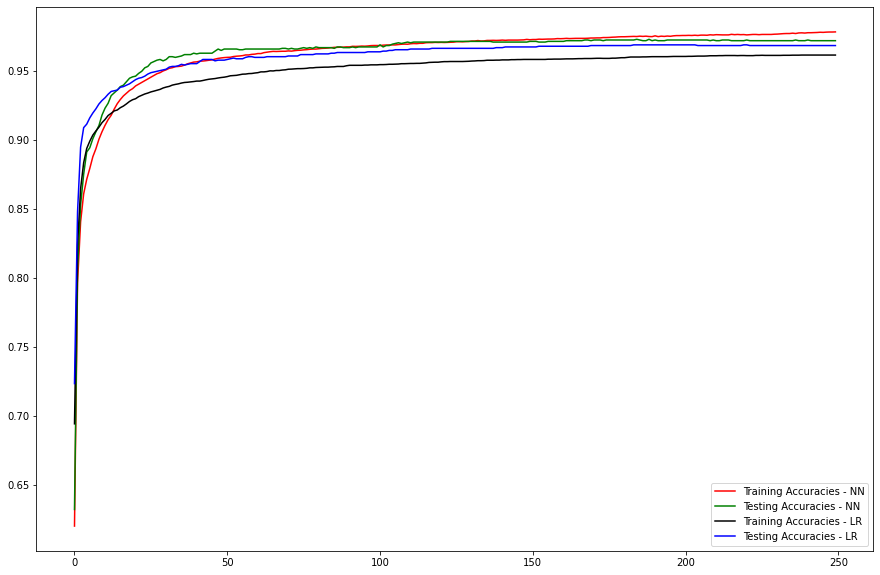

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

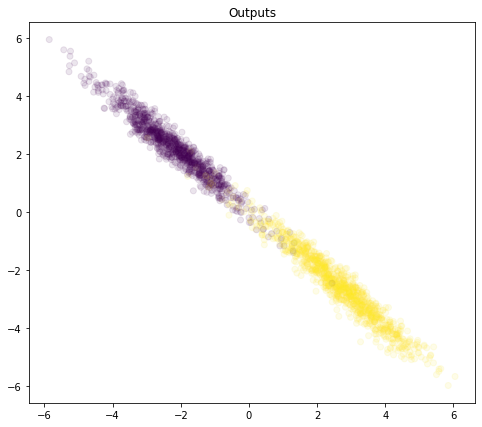

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

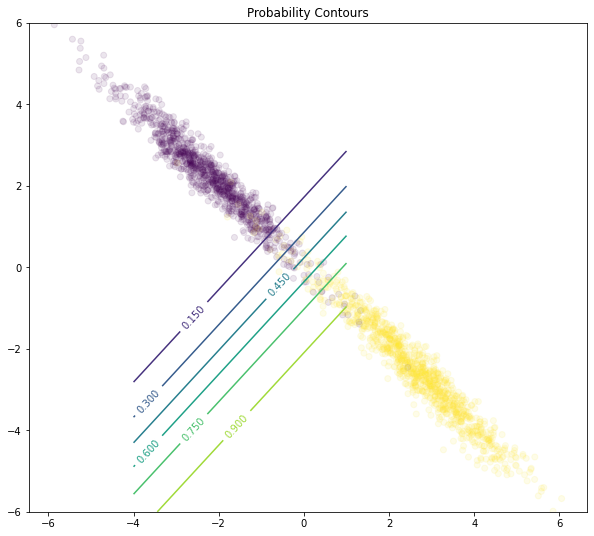

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );